**MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE**.

**Course: TC5035.10 - Integration project**

Tecnológico de Monterrey

Professor Dr. Horacio Martínez Alfaro

**Week 3, Activity 2**

Characteristics engineering

---

*   **Student:** Jorge Antonio Acosta Rosales
*   **Registration:** A01381552
*   **Student:** Israel Luján González
*   **Registration:** A01794693

In this phase, known as Feature Engineering (FE):

Common operations will be applied to convert the raw real-world data, into a set of variables useful for machine learning. Processing may include:
New feature generation
Discretization or binning
Coding (ordinal, one hot,...)
Scaling (normalization, standardization, min - max,...)
Transformation (logarithmic, exponential, square root, Box - Cox, Yeo - Johnson,...).
* All decisions and techniques employed must be justified.

---
A deep knowledge of the domain is demonstrated, by creating new and significant characteristics (if applicable). Categorical variables are coded using appropriate techniques. Each processing decision is justified.

Loading libraries for this project.

**Note:** we use uv tool to administrate the dependencies of the project
use the command below to install the dependencies
```bash
uv sync

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

In [21]:
# Load variables from .env file for local development or get it from the environment variables in production
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # Safe fallback if it's not available in prod

base_path = os.getenv("LSM_BASE")
if not base_path:
    raise ValueError("❌ Environment variable 'LSM_BASE' is not set!")

gestures_csv_path = os.path.join(base_path, "data", "metadata", "gestures_flat.csv")

In [22]:
# Load CSV file
gestures_raw_df = pd.read_csv(gestures_csv_path)

print("Summary of the datatypes and the values in the gestures dataset:")
display(gestures_raw_df.head())

Summary of the datatypes and the values in the gestures dataset:


,file_name,label,width,height,hand_count,hadedness_left,hadedness_right,confidence_left,confidence_right,right_x0,...,left_z17,left_x18,left_y18,left_z18,left_x19,left_y19,left_z19,left_x20,left_y20,left_z20
0,A_b9b32d87.jpg,A,640,640,1,0,1,NaN,0.997785,0.798897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A_d2b5d17d.jpg,A,640,640,1,0,1,NaN,0.997479,0.381789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A_9ff361f9.jpg,A,640,640,1,1,0,0.987826,NaN,NaN,...,-0.061392,0.71582,0.278875,-0.096776,0.671791,0.374887,-0.068303,0.657775,0.440908,-0.035481
3,A_e7bea9a5.jpg,A,640,640,1,0,1,NaN,0.985266,0.439434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A_750b0c55.jpg,A,640,640,1,0,1,NaN,0.984593,0.271182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


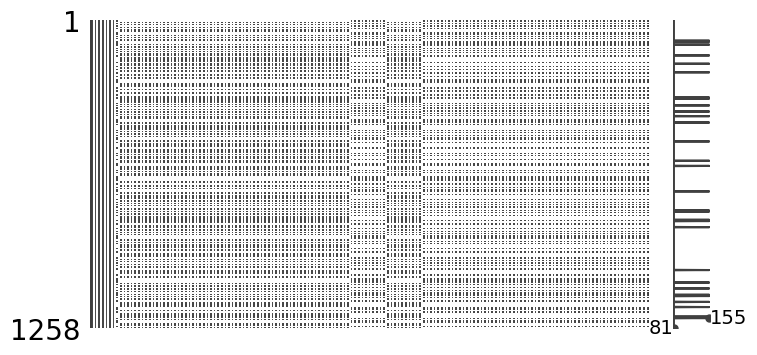

In [23]:
# Visualize missingness:
import missingno as msno
msno.matrix(gestures_raw_df, figsize=(8,4))
plt.show()

We start with the dataset transformation based in the analysis of the data that we did in the EDA activity.

In [24]:
# Work off a copy so you don’t overwrite your original
df = gestures_raw_df.copy()

# Replace NaNs in confidence with 0 so comparisons won’t break
df['confidence_left_f']  = df['confidence_left'].fillna(0)
df['confidence_right_f'] = df['confidence_right'].fillna(0)

# Decide which hand “wins” (higher confidence)
df['preferred_hand'] = np.where(
    df['confidence_left_f'] >= df['confidence_right_f'],
    'left',
    'right'
)

# Start your new DataFrame with the columns you still want
cols_to_keep = ['file_name','label','width','height','hand_count']
gestures_df = df[cols_to_keep].copy()

# Unified handedness & confidence
gestures_df['handedness'] = df['preferred_hand']
gestures_df['confidence']  = np.where(
    df['preferred_hand']=='left',
    df['confidence_left'],
    df['confidence_right']
)

# Pull in the 21 landmarks for whichever side was chosen
for axis in ('x','y','z'):
    for i in range(21):
        left_col  = f'left_{axis}{i}'
        right_col = f'right_{axis}{i}'
        new_col   = f'{axis}{i}'
        # choose left_<axis><i> if preferred_hand=='left', else right_<axis><i>
        gestures_df[new_col] = np.where(
            df['preferred_hand']=='left',
            df[left_col],
            df[right_col]
        )

# Pull in engineered distances & angles for just the winning hand
fingers = ["thumb","index","middle","ring","pinky"]
for finger in fingers:
    # distance feature
    gestures_df[f"{finger}_dist"] = np.where(
        df['preferred_hand']=='left',
        df[f'left_{finger}_dist'],
        df[f'right_{finger}_dist']
    )
    # angle feature
    gestures_df[f"{finger}_angle"] = np.where(
        df['preferred_hand']=='left',
        df[f'left_{finger}_angle'],
        df[f'right_{finger}_angle']
    )

# Keep only rows with hand_count not equal to 2
gestures_df = gestures_df[gestures_df['hand_count'] != 2].reset_index(drop=True)

In [25]:
gestures_df.head()

,file_name,label,width,height,hand_count,handedness,confidence,x0,x1,x2,...,thumb_dist,thumb_angle,index_dist,index_angle,middle_dist,middle_angle,ring_dist,ring_angle,pinky_dist,pinky_angle
0,A_b9b32d87.jpg,A,640,640,1,right,0.997785,0.798897,0.725475,0.570459,...,0.615069,162.072725,0.428294,149.142996,0.400321,154.507508,0.375774,160.232554,0.366992,163.426065
1,A_d2b5d17d.jpg,A,640,640,1,right,0.997479,0.381789,0.559909,0.685032,...,0.621105,162.560841,0.425830,148.724763,0.398358,155.136401,0.374649,161.810152,0.365546,165.570584
2,A_9ff361f9.jpg,A,640,640,1,left,0.987826,0.606538,0.442157,0.319858,...,0.611691,163.256617,0.438740,148.753663,0.392533,154.831782,0.359303,158.650349,0.356963,160.237081
3,A_e7bea9a5.jpg,A,640,640,1,right,0.985266,0.439434,0.591480,0.702281,...,0.568575,154.395800,0.312348,130.816186,0.270621,131.528817,0.273953,142.488172,0.313761,154.101684
4,A_750b0c55.jpg,A,640,640,1,right,0.984593,0.271182,0.331742,0.484159,...,0.570004,155.083940,0.312544,130.410206,0.271806,131.407179,0.275288,142.368124,0.316213,154.106598


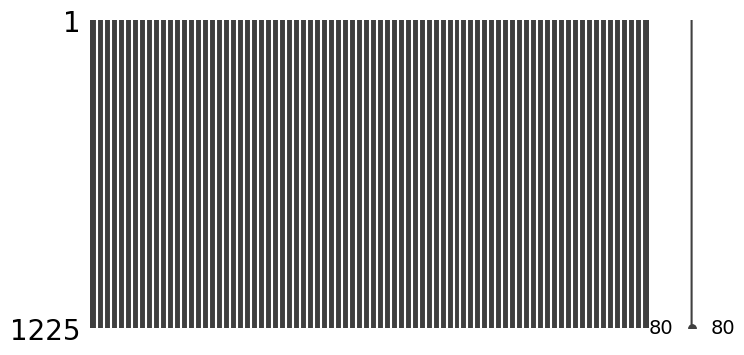

In [26]:
msno.matrix(gestures_df, figsize=(8,4))
plt.show()

As we discussed in the EDA, the columns of width, height and hand_count for now are not usful and don't apport any information to the model, so we will drop them.

In [27]:
gestures_df.drop(columns=['file_name', 'width', 'height', 'hand_count'], inplace=True)

In [28]:
# Updating numerical columns and categorical
numerical_columns = gestures_df.select_dtypes(include = ['int', 'float']).columns
categorical_columns = gestures_df.select_dtypes(include = ['object','category']).columns

print("Numerical columns: ", numerical_columns.to_list())
print("Categorical columns: ", categorical_columns.to_list())
print(f"Number of numerical columns: {len(numerical_columns)}")
print(f"Number of categorical columns: {len(categorical_columns)}")  

Numerical columns:  ['confidence', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16', 'z17', 'z18', 'z19', 'z20', 'thumb_dist', 'thumb_angle', 'index_dist', 'index_angle', 'middle_dist', 'middle_angle', 'ring_dist', 'ring_angle', 'pinky_dist', 'pinky_angle']
Categorical columns:  ['label', 'handedness']
Number of numerical columns: 74
Number of categorical columns: 2


**Note:** It is necessary to emphasize that if you see what is done in the script of `getting_metadata.py` is previously made a nesting of new data in the category of `enginnered` in which are included the disntancias of the fingers and the angles of the same with respect to the wrist, this is done so that the model can learn in a more efficient way and not only with the original data. This was proposed by our team thanks to a research work where other universities when facing a similar challenge, showed that having this type of data helps to improve the accuracy of the trained models.

Now we are going to show the distribution of the data and based on that we will take the best decision for the normalization of the data, as well as the reduction of the same since the EDA showed that the correlation of many is redundant and can reduce the performance of the model.

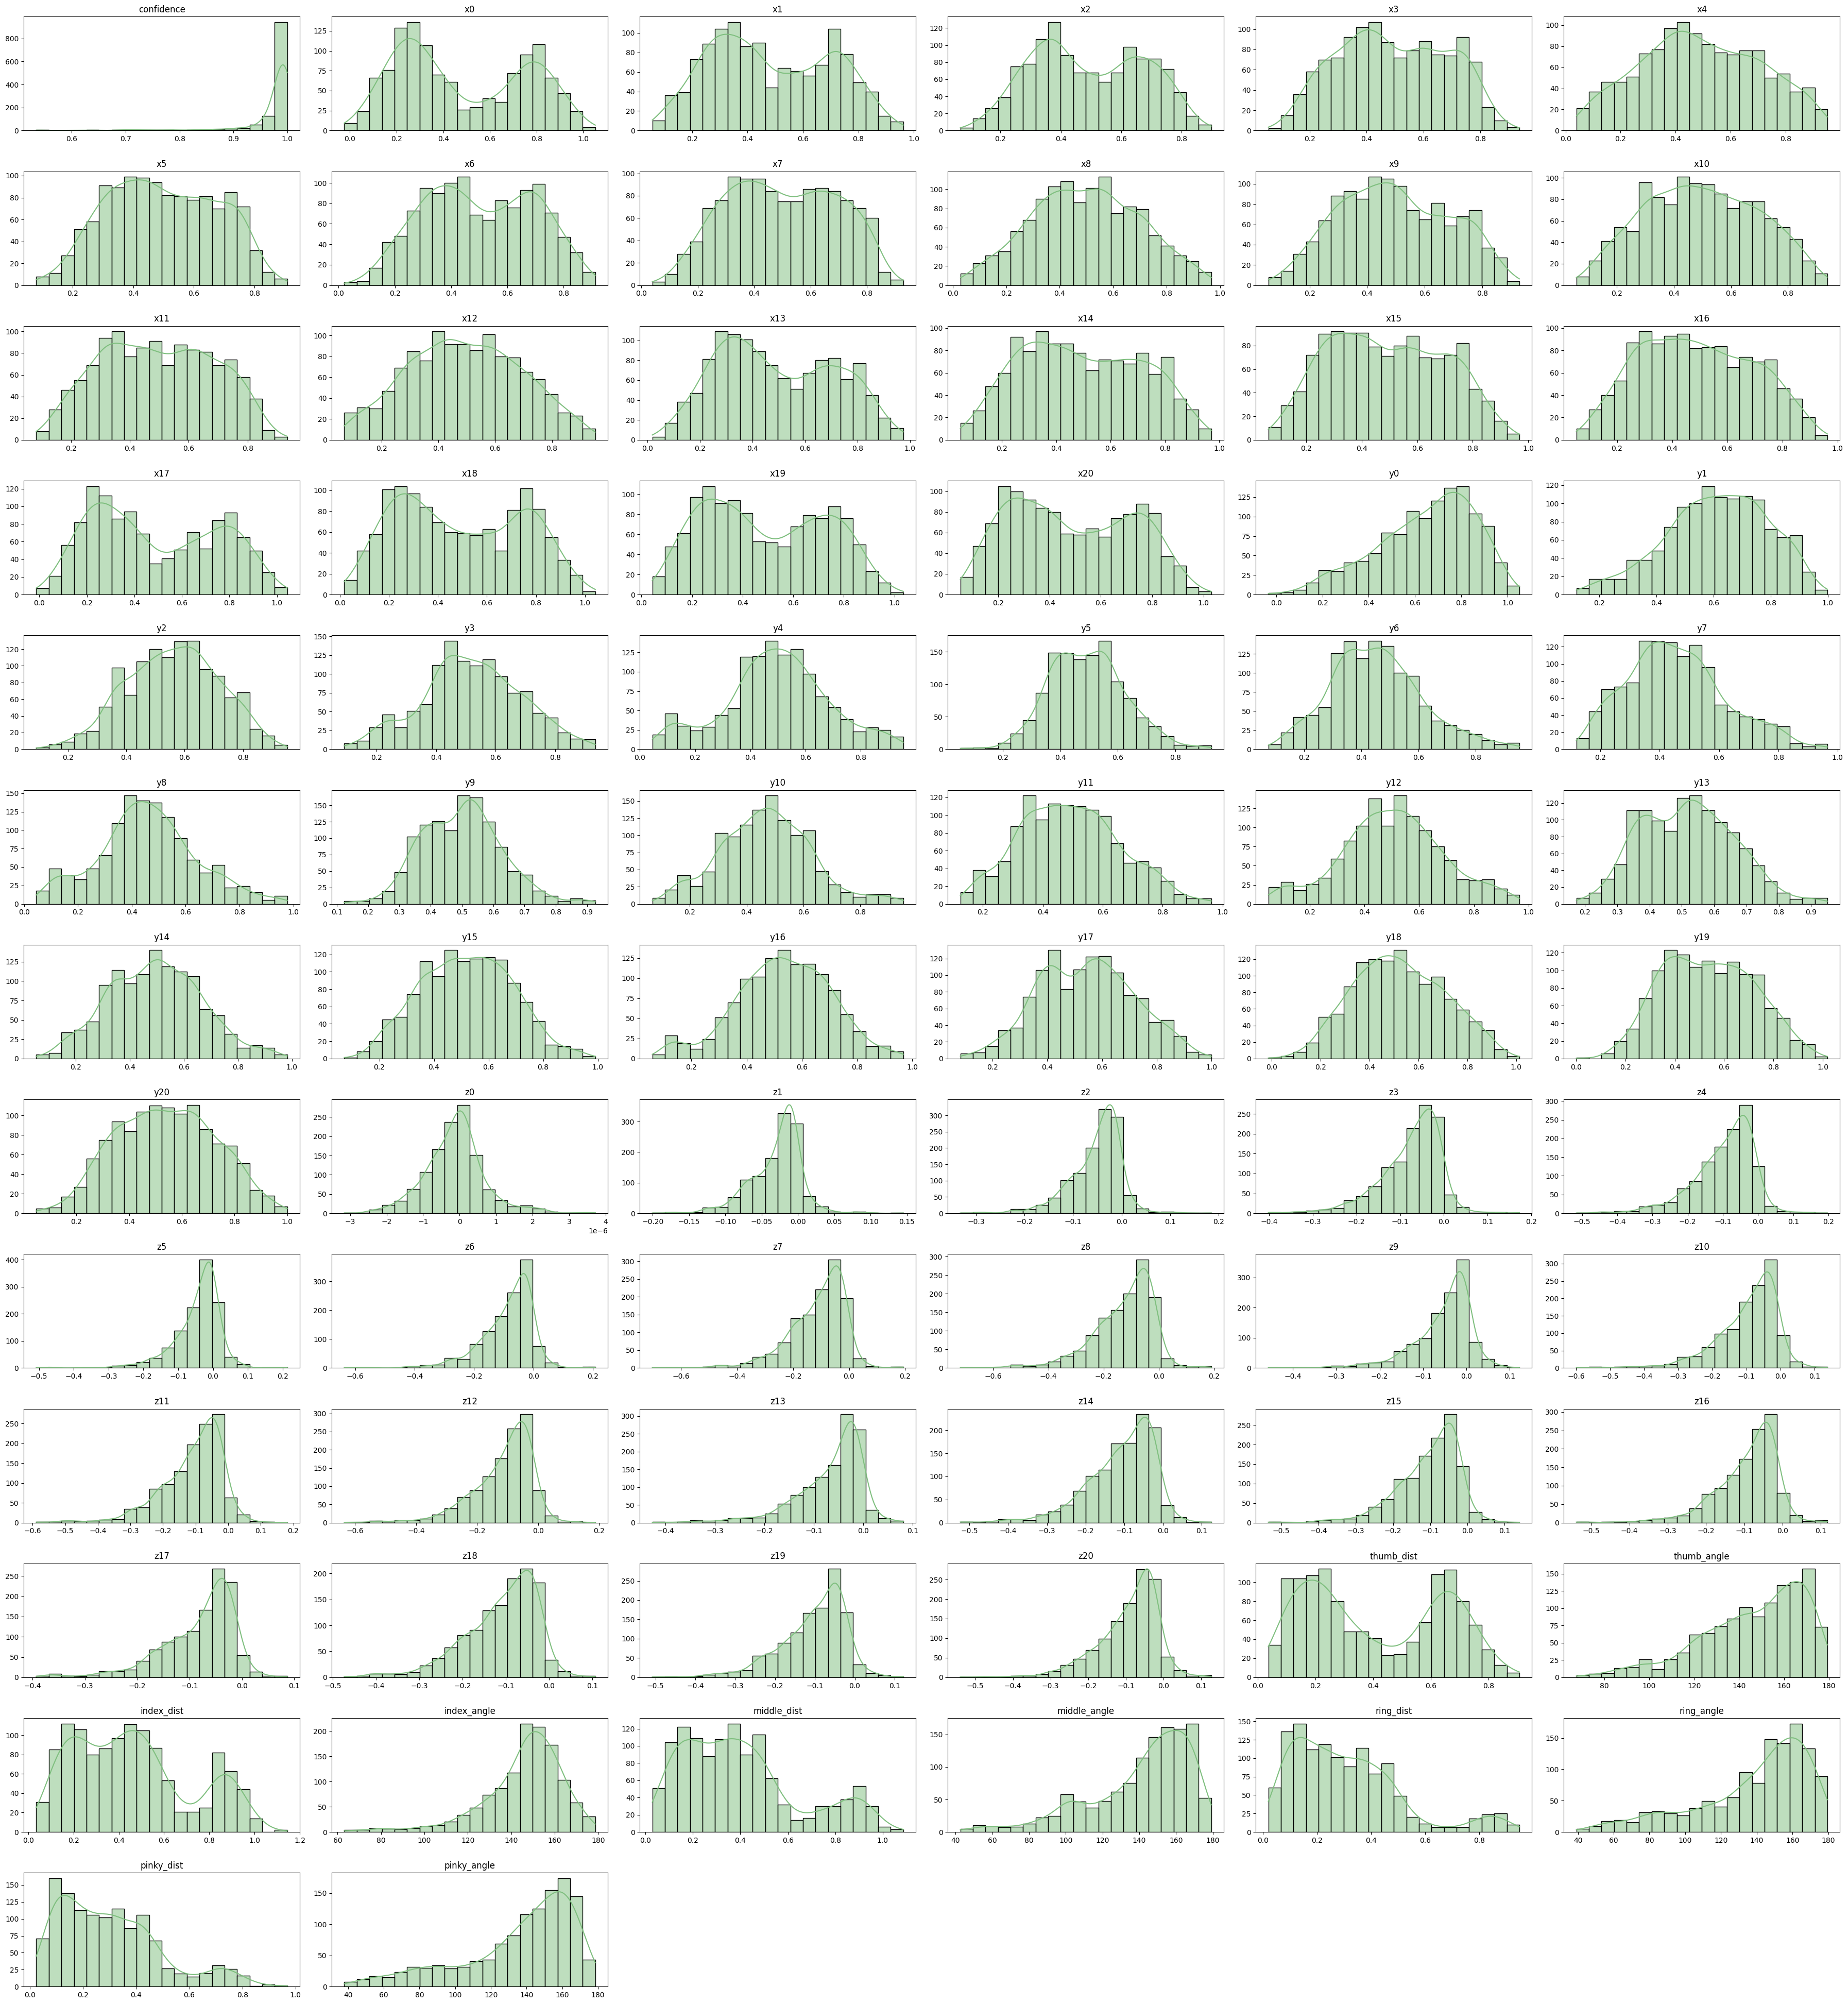

In [29]:
# Compute grid size
n = len(numerical_columns)
ncols = 6
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

# Plot each histogram
for ax, col in zip(axes, numerical_columns):
    sns.histplot(gestures_df[col].dropna(), kde=True, bins=20, ax=ax, color='#7fbf7f')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Review of each group of columns.

* **confidence**

their values are between 0.55 and 1 but the great majority of the values are between 0.9 and 1.0, so the information that we can extract from this columns is not relevant for the moment, because we have a small amount of samples and that provoque that the data is not spreaded enough. in the future we can include this column to train the model, but for practical purposes we are going to drop this column.


* **X-Coordinate Landmarks (x0–x20)**
  All x-values lie between 0 and 1, confirming they’re already normalized. Many fingertip and joint positions display clear bimodal or multimodal patterns—certain gestures cluster landmarks on the left side of the frame (≈0.2–0.4) versus the right side (≈0.6–0.8). These distributional shapes carry semantic information about different signs. Because they’re on a consistent scale, no further normalization is required, though reducing dimensionality (e.g. via PCA) could help tame redundancy across 21 points.

* **Y-Coordinate Landmarks (y0–y20)**
  Similarly bound to \[0,1], the y-values form roughly bell-shaped curves, with means around 0.5–0.7. This reflects that hands tend to appear in the lower half of the image. The unimodal shapes and modest skew imply that no nonlinear transformation is necessary for these features.

* **Z-Coordinate Landmarks (z0–z20)**
  Depth coordinates center near zero but exhibit a rightward tail of positive values. While these are also on a small scale, their skew suggests a mild transformation (for example, `log1p` after shifting) could make them more symmetrically distributed if depth turns out to be predictive.

* **Outlier and Artifact Handling**
  A handful of landmark values fall slightly below 0 or exceed 1—these are clearly detection artifacts. We will clip or remove any coordinate outside the valid \[0,1] range to ensure consistency.

---

**Preprocessing Decisions**

1. **Drop or De-emphasize confidence** since it has near-zero variance.
2. **Apply a gentle log-transform** to z-coordinates if needed to address skew.
3. **Shift the data of Z-coordinates** to center around 0.5, to match with the other X/Y axes.
3. **Clip all x/y/z values to \[0,1]**, eliminating any artifacts.
4. **Consider dimensionality reduction** (PCA or an autoencoder) on the 63 landmark features to distill the most informative patterns.



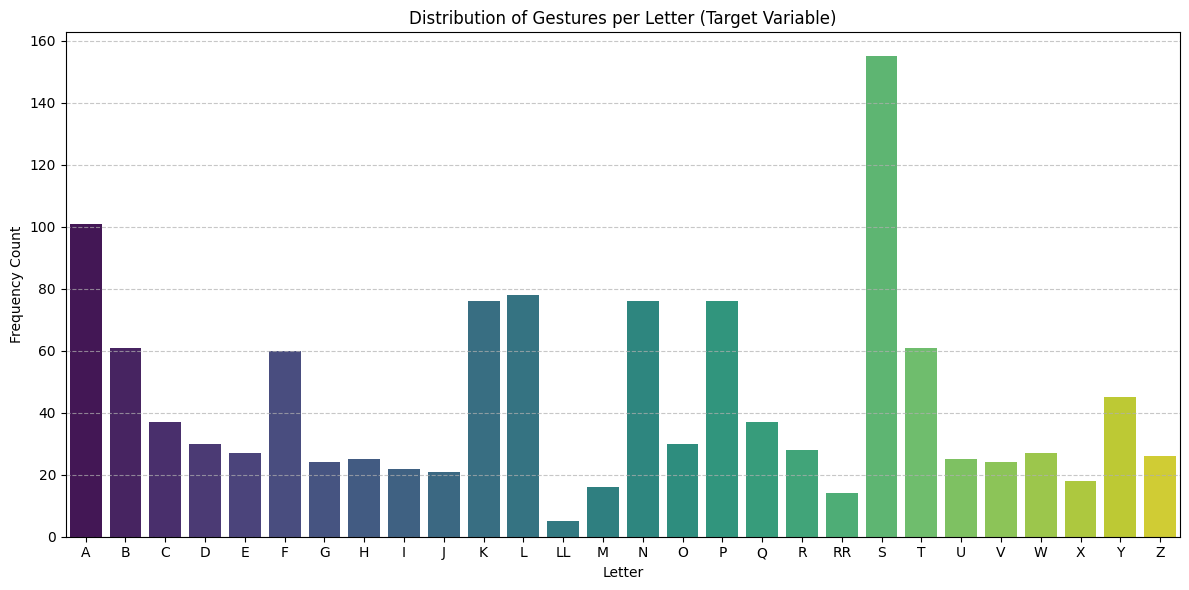

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=gestures_df, x='label', hue='label', palette='viridis')

plt.title('Distribution of Gestures per Letter (Target Variable)')
plt.xlabel('Letter')
plt.ylabel('Frequency Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

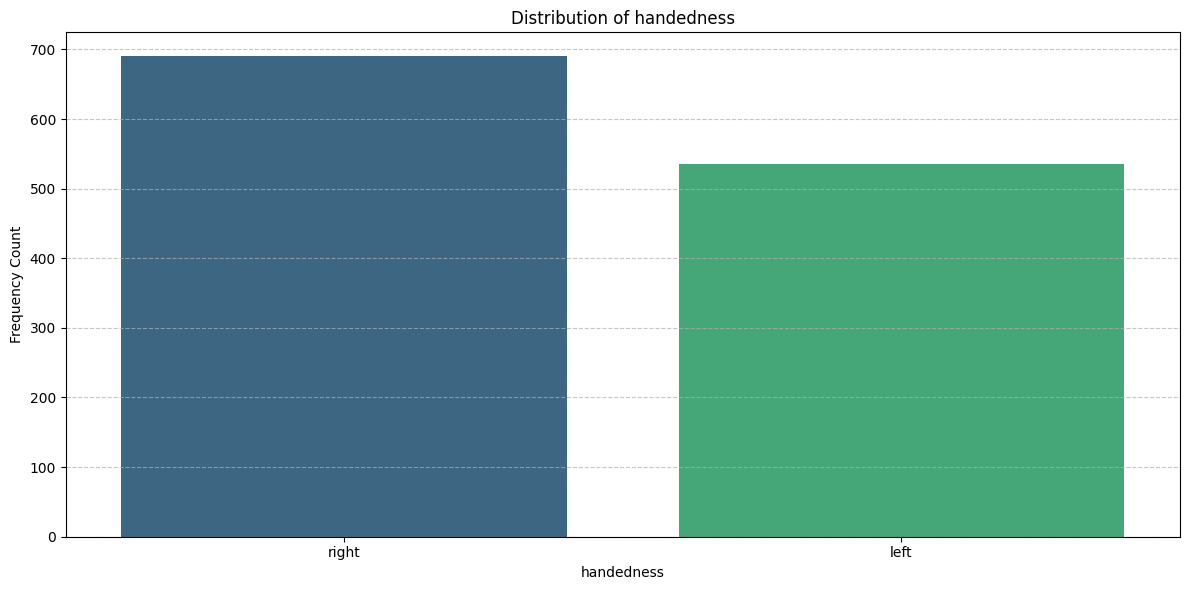

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(data=gestures_df, x='handedness', hue='handedness', palette='viridis')

plt.title('Distribution of handedness')
plt.xlabel('handedness')
plt.ylabel('Frequency Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Based in this information we mantain the same recomendations that we did in the EDA activity, we have a big problem of class imbalance, and the data argumentation is not a good option because a great majority of our images are already augmented, so we are going to try to use the SMOTE algorithm to balance the data, in review the results, if is not good enough we can try other methods like ADASYN or BorderlineSMOTE.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def preprocess(df: pd.DataFrame, apply_pca: bool = True, pca_variance: float = 0.95):
    # 1) Drop near-constant confidence
    df = df.drop(columns=['confidence'], errors='ignore')

    # 2) Identify columns
    x_cols = [f'x{i}' for i in range(21)]
    y_cols = [f'y{i}' for i in range(21)]
    z_cols = [f'z{i}' for i in range(21)]
    coords = x_cols + y_cols + z_cols

    # 3) Shift Z so mean → 0.5, then log1p
    z_mean = df[z_cols].mean()
    shift = 0.5 - z_mean
    df[z_cols] = np.log1p(df[z_cols] + shift)

    # 4) Clip all coords to [0,1]
    df[coords] = df[coords].clip(0.0, 1.0)

    # 5) Optional PCA on 63 dims
    if apply_pca:
        pca = PCA(n_components=pca_variance, svd_solver='full')
        transformed = pca.fit_transform(df[coords])
        cols_pca = [f'PC{i+1}' for i in range(transformed.shape[1])]
        return pd.DataFrame(transformed, columns=cols_pca, index=df.index)

    return df



In addition, filtering methods for feature selection and feature extraction techniques will be used, allowing to reduce storage requirements, model complexity and training time. The following examples are illustrative, but not exhaustive, of what could be applied:
Variance threshold
Correlation
Chi-square
ANOVA
Principal component analysis (PCA)
Factor analysis (FA)
The methods performed need to be substantiated.

---

Variables are scaled to ensure that all have an equal impact on the model and to improve the convergence of some algorithms. Common transformations are applied to achieve a normal distribution for some variables, if necessary for the context and analysis objectives. Each technique used is justified

---
Filtering and extraction methods are applied, aligned to the results obtained from the tests performed, to reduce complexity, accelerate the training process and facilitate the interpretation of the results.


Include conclusions from the "Data Preparation" phase in the context of the CRISP-ML methodology.

---
A general conclusion of the Data Preparation phase in the context of the CRISP-ML methodology is included.